회귀 모델: 연속적인 결과를 예측하는 데 사용. 예를 들어, 주택 가격이나 온도 예측과 같이 숫자 값을 예측하는 데에 적용.
분류 모델: 두 개 이상의 범주 중 하나로 분류하는 데에 사용.남자 or 여자

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 생성
np.random.seed(seed=0) # 난수 고정
X_min = 0
X_max = 2.5
X_n = 30
X_col = ["cornflowerblue", "gray"]


X = np.zeros(X_n) # 입력 데이터
T = np.zeros(X_n, dtype=np.uint8) # 목표 데이터
Dist_s = [0.4, 0.8] # 분포의 시작 지점
Dist_w = [0.8, 1.6] # 분포의 폭
Pi = 0.5 #클래스 0의 비율
for n in range(X_n):
    wk = np.random.rand()
    T[n] = 0 * (wk < Pi) + 1 * (wk >= Pi) # (A)
    X[n] = np.random.rand() * Dist_w[T[n]] + Dist_s[T[n]] # (B) 암컷일 시 Dist_s[0] = 0.4 ~ Dist_w[0] = 0.8의 균일한 분포에서 질량 샘플링
                                                          #     수컷일 시 Dist_s[0] = 0.8 ~ Dist_w[0] = 1.6의 균일한 분포에서 질량 샘플링

# 데이터 표시
print("X=" + str(np.round(X, 2)))
print("T=" + str(T))

X=[1.94 1.67 0.92 1.11 1.41 1.65 2.28 0.47 1.07 2.19 2.08 1.02 0.91 1.16
 1.46 1.02 0.85 0.89 1.79 1.89 0.75 0.9  1.87 0.5  0.69 1.5  0.96 0.53
 1.21 0.6 ]
T=[1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0]


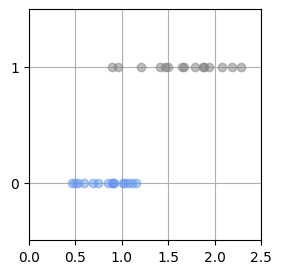

In [4]:
def show_data1(x, t):

    K = np.max(t) + 1

    for k in range(K): # (A)

        plt.plot(x[t == k], t[t == k], X_col[k], alpha=0.5, linestyle='none', marker='o') # (B)
        plt.grid(True)
        plt.ylim(-.5, 1.5)
        plt.xlim(X_min, X_max)
        plt.yticks([0, 1])

fig = plt.figure(figsize=(3, 3))
show_data1(X, T)
plt.show()

# **선형 회귀 모델을 이용한다면 오히려 더 확실하게 수컷인 지점에 대해 오차가 커짐**

그래서 확률론적 모델 도입

In [5]:
# 로지스틱 회귀 모델
def logistic(x, w):
    y = 1 / (1 + np.exp(-(w[0] * x + w[1])))
    return y

1.25

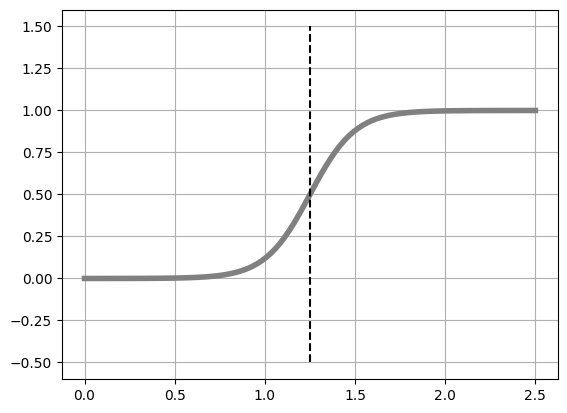

In [6]:
def show_logistic(w):
    xb = np.linspace(X_min, X_max, 100)
    y = logistic(xb, w)
    plt.plot(xb, y, color='gray', linewidth=4)
    # 결정 경계와 표시
    i = np.min(np.where(y > 0.5)) # (A)
    B = (xb[i - 1] + xb[i]) / 2 # (B)
    plt.plot([B, B], [-.5, 1.5], color='k', linestyle='--')
    plt.grid(True)
    return B


# test
W = [8, -10]
show_logistic(W)


In [7]:

# 교차 엔트로피 오차 계산
def cee_logistic(w, x, t):
    y = logistic(x, w)
    cee = 0
    for n in range(len(y)):
        cee = cee - (t[n] * np.log(y[n]) + (1 - t[n]) * np.log(1 - y[n]))
    cee = cee / X_n
    return cee


# test
W=[1,1]
cee_logistic(W, X, T)

1.0288191541851066

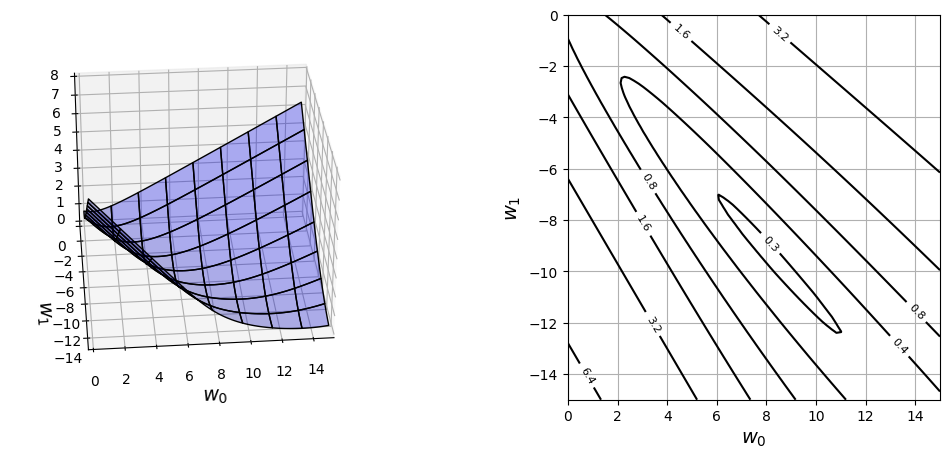

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# 평균 교차 엔트로피 오차 형태 확인
xn = 80 # 등고선 표시 해상도
w_range = np.array([[0, 15], [-15, 0]])
x0 = np.linspace(w_range[0, 0], w_range[0, 1], xn)
x1 = np.linspace(w_range[1, 0], w_range[1, 1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
C = np.zeros((len(x1), len(x0)))
w = np.zeros(2)
for i0 in range(xn):
    for i1 in range(xn):
        w[0] = x0[i0]
        w[1] = x1[i1]
        C[i1, i0] = cee_logistic(w, X, T)


plt.figure(figsize=(12, 5))
#plt.figure(figsize=(9.5, 4))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx0, xx1, C, color='blue', edgecolor='black',
                rstride=10, cstride=10, alpha=0.3)
ax.set_xlabel('$w_0$', fontsize=14)
ax.set_ylabel('$w_1$', fontsize=14)
ax.set_xlim(0, 15)
ax.set_ylim(-15, 0)
ax.set_zlim(0, 8)
ax.view_init(30, -95)


plt.subplot(1, 2, 2)
cont = plt.contour(xx0, xx1, C, 20, colors='black',
                   levels=[0.26, 0.4, 0.8, 1.6, 3.2, 6.4])
cont.clabel(fmt='%1.1f', fontsize=8)
plt.xlabel('$w_0$', fontsize=14)
plt.ylabel('$w_1$', fontsize=14)
plt.grid(True)
plt.show()

In [11]:
# 평균 교차 엔트로피 오차의 미분
def dcee_logistic(w, x, t):
    y = logistic(x, w)
    dcee = np.zeros(2)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n] - t[n]) * x[n]
        dcee[1] = dcee[1] + (y[n] - t[n])
    dcee = dcee / X_n
    return dcee


# --- test
W=[1, 1]
dcee_logistic(W, X, T)

array([0.30857905, 0.39485474])

w0 = 8.18, w1 = -9.38
CEE = 0.25
Boundary = 1.15 g


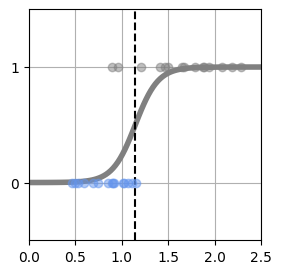

In [12]:
from scipy.optimize import minimize


# 매개 변수 검색
def fit_logistic(w_init, x, t):
    res1 = minimize(cee_logistic, w_init, args=(x, t),
                    jac=dcee_logistic, method="CG") # (A)
    return res1.x


plt.figure(1, figsize=(3, 3))
W_init=[1,-1]
W = fit_logistic(W_init, X, T)
print("w0 = {0:.2f}, w1 = {1:.2f}".format(W[0], W[1]))
B=show_logistic(W)
show_data1(X, T)
plt.ylim(-.5, 1.5)
plt.xlim(X_min, X_max)
cee = cee_logistic(W, X, T)
print("CEE = {0:.2f}".format(cee))
print("Boundary = {0:.2f} g".format(B))
plt.show()

In [13]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 생성
np.random.seed(seed=1)  # 난수를 고정
N = 100 # 데이터의 수
K = 3 # 분포 수
T3 = np.zeros((N, 3), dtype=np.uint8) # 2클래스 분류 데이터
T2 = np.zeros((N, 2), dtype=np.uint8) # 3클래스 분류 데이터
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0 범위 표시 용
X_range1 = [-3, 3] # X1의 범위 표시 용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율 0.4 0.8 1
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])
T2[:, 0] = T3[:, 0]
T2[:, 1] = T3[:, 1] | T3[:, 2]

In [14]:
print(X[:5,:])

[[-0.14173827  0.86533666]
 [-0.86972023 -1.25107804]
 [-2.15442802  0.29474174]
 [ 0.75523128  0.92518889]
 [-1.10193462  0.74082534]]


In [15]:
print(T2[:5,:])

[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [16]:
print(T3[:5,:])

[[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


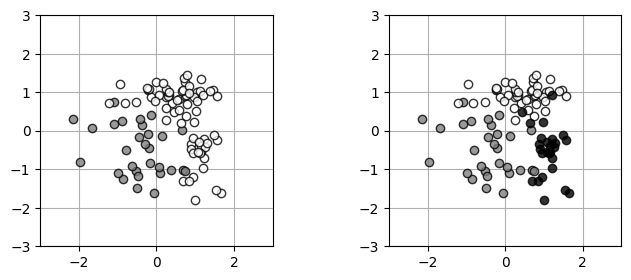

In [17]:
# 데이터 표시
def show_data2(x, t):
    wk, K = t.shape
    c = [[.5, .5, .5], [1, 1, 1], [0, 0, 0]]
    for k in range(K):
        plt.plot(x[t[:, k] == 1, 0], x[t[:, k] == 1, 1],
                 linestyle='none', markeredgecolor='black',
                 marker='o', color=c[k], alpha=0.8)
        plt.grid(True)


# 메인
plt.figure(figsize=(7.5, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
show_data2(X, T2)
plt.xlim(X_range0)
plt.ylim(X_range1)


plt.subplot(1, 2, 2)
show_data2(X, T3)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

In [18]:
def logistic2(x0, x1, w):
    y = 1 / (1 + np.exp(-(w[0] * x0 + w[1] * x1 + w[2])))
    return y

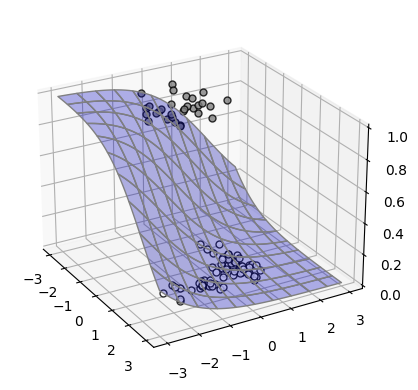

In [19]:
from mpl_toolkits.mplot3d import axes3d

# 모델 3d보기
def show3d_logistic2(ax, w):
    xn = 50
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    ax.plot_surface(xx0, xx1, y, color='blue', edgecolor='gray',
                    rstride=5, cstride=5, alpha=0.3)


def show_data2_3d(ax, x, t):
    c = [[.5, .5, .5], [1, 1, 1]]
    for i in range(2):
        ax.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], 1 - i,
                marker='o', color=c[i], markeredgecolor='black',
                linestyle='none', markersize=5, alpha=0.8)
    Ax.view_init(elev=25, azim=-30)


# test ---
Ax = plt.subplot(1, 1, 1, projection='3d')
W=[-1, -1, -1]
show3d_logistic2(Ax, W)
show_data2_3d(Ax,X,T2)

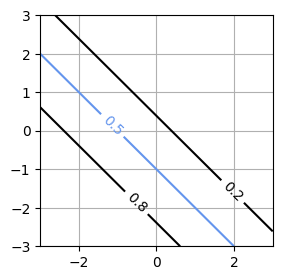

In [20]:
# 모델 등고선 2d 표시
def show_contour_logistic2(w):
    xn = 30 # 파라미터의 분할 수
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    cont = plt.contour(xx0, xx1, y, levels=(0.2, 0.5, 0.8),
                       colors=['k', 'cornflowerblue', 'k'])
    cont.clabel(fmt='%1.1f', fontsize=10)
    plt.grid(True)


# test ---
plt.figure(figsize=(3,3))
W=[-1, -1, -1]
show_contour_logistic2(W)


In [21]:
# 크로스 엔트로피 오차
def cee_logistic2(w, x, t):
    X_n = x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    cee = 0
    for n in range(len(y)):
        cee = cee - (t[n, 0] * np.log(y[n]) +
                     (1 - t[n, 0]) * np.log(1 - y[n]))
    cee = cee / X_n
    return cee

In [22]:
# 크로스 엔트로피 오차의 미분
def dcee_logistic2(w, x, t):
    X_n=x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    dcee = np.zeros(3)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n] - t[n, 0]) * x[n, 0]
        dcee[1] = dcee[1] + (y[n] - t[n, 0]) * x[n, 1]
        dcee[2] = dcee[2] + (y[n] - t[n, 0])
    dcee = dcee / X_n
    return dcee


# test ---
W=[-1, -1, -1]
dcee_logistic2(W, X, T2)

array([ 0.10272008,  0.04450983, -0.06307245])

w0 = -3.70, w1 = -2.54, w2 = -0.28
CEE = 0.22


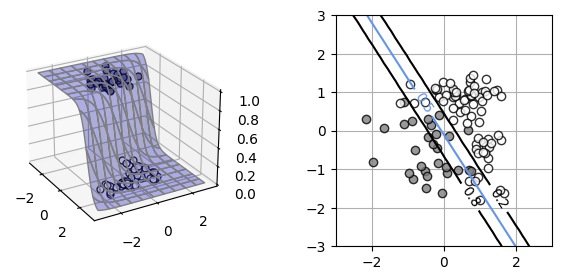

In [23]:
from scipy.optimize import minimize


# 로지스틱 회귀 모델의 매개 변수 검색
def fit_logistic2(w_init, x, t):
    res = minimize(cee_logistic2, w_init, args=(x, t),
                   jac=dcee_logistic2, method="CG")
    return res.x


# 메인
plt.figure(1, figsize=(7, 3))
plt.subplots_adjust(wspace=0.5)


Ax = plt.subplot(1, 2, 1, projection='3d')
W_init = [-1, 0, 0]
W = fit_logistic2(W_init, X, T2)
print("w0 = {0:.2f}, w1 = {1:.2f}, w2 = {2:.2f}".format(W[0], W[1], W[2]))
show3d_logistic2(Ax, W)


show_data2_3d(Ax, X, T2)
cee = cee_logistic2(W, X, T2)
print("CEE = {0:.2f}".format(cee))


Ax = plt.subplot(1, 2, 2)
show_data2(X, T2)
show_contour_logistic2(W)
plt.show()

In [24]:
#3클래스용 로지스틱 회귀 모델
def logistic3(x0, x1, w):
    K = 3
    w = w.reshape((3, 3))
    n = len(x1)
    y = np.zeros((n, K))
    for k in range(K):
        y[:, k] = np.exp(w[k, 0] * x0 + w[k, 1] * x1 + w[k, 2])
    wk = np.sum(y, axis=1)
    wk = y.T / wk
    y = wk.T
    return y


# test ---
W = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9])
y = logistic3(X[:3, 0], X[:3, 1], W)
print(np.round(y, 3))

[[0.    0.006 0.994]
 [0.965 0.033 0.001]
 [0.925 0.07  0.005]]


In [25]:
# 교차 엔트로피 오차
def cee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:, 0], x[:, 1], w)
    cee = 0
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            cee = cee - (t[n, k] * np.log(y[n, k]))
    cee = cee / X_n
    return cee


# test
W = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9])
cee_logistic3(W, X, T3)

3.9824582404787288

In [26]:
# 교차 엔트로피 오차의 미분
def dcee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:, 0], x[:, 1], w)
    dcee = np.zeros((3, 3)) # (클래스의 수 K) x (x의 차원 D+1)
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            dcee[k, :] = dcee[k, :] - (t[n, k] - y[n, k])* np.r_[x[n, :], 1]
    dcee = dcee / X_n
    return dcee.reshape(-1)


# test
W = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9])
dcee_logistic3(W, X, T3)

array([ 0.03778433,  0.03708109, -0.1841851 , -0.21235188, -0.44408101,
       -0.38340835,  0.17456754,  0.40699992,  0.56759346])

In [27]:

# 매개 변수 검색
def fit_logistic3(w_init, x, t):
    w_init_flat = w_init.ravel()
    res = minimize(cee_logistic3, w_init_flat, args=(x, t),
                   jac=dcee_logistic3, method="CG")
    return res.x

In [28]:
# 모델 등고선 2d 표시
def show_contour_logistic3(w):

    xn = 30 # 파라미터의 분할 수
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)


    xx0, xx1 = np.meshgrid(x0, x1)
    y = np.zeros((xn, xn, 3))

    for i in range(xn):

        wk = logistic3(xx0[:, i], xx1[:, i], w)

        for j in range(3):

            y[:, i, j] = wk[:, j]

    for j in range(3):

        cont = plt.contour(xx0, xx1, y[:, :, j],
                           levels=(0.5, 0.9),
                           colors=['cornflowerblue', 'k'])
        cont.clabel(fmt='%1.1f', fontsize=9)

    plt.grid(True)


[[-3.2  -2.69  2.25]
 [-0.49  4.8  -0.69]
 [ 3.68 -2.11 -1.56]]
CEE = 0.23


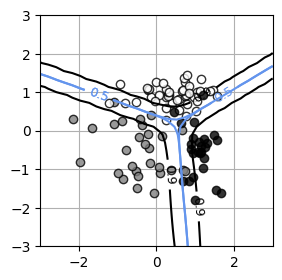

In [29]:
W_init = np.zeros((3, 3))
W = fit_logistic3(W_init, X, T3)
print(np.round(W.reshape((3, 3)),2))
cee = cee_logistic3(W, X, T3)
print("CEE = {0:.2f}".format(cee))


plt.figure(figsize=(3, 3))
show_data2(X, T3)
show_contour_logistic3(W)
plt.show()